# Initial travel network

In this notebook we will create the network of travels before the start of pandemic, our goal is to have a initial network so that we can remove the edges from the restrictions that occurs. The data is from [OpenFlights](https://openflights.org/data.html), there is data from the different travel routes with with details of the airline of the travel and the source and destination airports. The data was updated until 2014.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import json

In [3]:
airlines = pd.read_csv('data/airlines.dat', header = None, names = ['airline_id', 'name', 'alias', 'iata', 
                                                      'icao', 'callsign', 'country', 'active'] )

airports = pd.read_csv('data/airports.dat', header = None, names = ['airport_id', 'name', 'city', 'country',
                                                                 'iata', 'icao', 'latitude', 'longitude',
                                                                 'altitude','timezone','dst', 'tz_database_time_zone',
                                                                 'type', 'source'])
routes = pd.read_csv('data/routes.dat', header = None, names = ['airline', 'airline_id', 'source_airport', 'source_airport_id',
                                                             'destination_airport','destination_airport_id', 'codeshare', 'stops',
                                                             'equipment'])

#replacing NaN values identifier
for df in [airlines, airports, routes]:
    df.replace({"\\N" : None}, inplace = True)
    
routes['source_airport_id'] = routes['source_airport_id'].astype(float)
routes['destination_airport_id'] = routes['destination_airport_id'].astype(float)

With which route, we need to correlate their airports to the country of destination and origin, the most important information for building the network.

In [4]:
routes = pd.merge(routes, airports[['airport_id', 'country', 'latitude', 'longitude']], 
         left_on = 'source_airport_id', right_on = 'airport_id', how = 'left')
routes.drop(columns = ['airport_id'], inplace = True)
routes.rename(columns = {'country': 'source_country', 'latitude':'source_latitude', 'longitude': 'source_longitude'}, 
              inplace = True)
routes = pd.merge(routes, airports[['airport_id', 'country', 'latitude', 'longitude']], 
         left_on = 'destination_airport_id', right_on = 'airport_id', how = 'left')
routes.drop(columns = ['airport_id'], inplace = True)
routes.rename(columns = {'country': 'destination_country', 'latitude':'destination_latitude', 'longitude': 'destination_longitude'}, 
              inplace = True)
routes

,airline,airline_id,source_airport,source_airport_id,destination_airport,destination_airport_id,codeshare,stops,equipment,source_country,source_latitude,source_longitude,destination_country,destination_latitude,destination_longitude
0,2B,410,AER,2965.0,KZN,2990.0,NaN,0,CR2,Russia,43.449902,39.956600,Russia,55.606201,49.278702
1,2B,410,ASF,2966.0,KZN,2990.0,NaN,0,CR2,Russia,46.283298,48.006302,Russia,55.606201,49.278702
2,2B,410,ASF,2966.0,MRV,2962.0,NaN,0,CR2,Russia,46.283298,48.006302,Russia,44.225101,43.081902
3,2B,410,CEK,2968.0,KZN,2990.0,NaN,0,CR2,Russia,55.305801,61.503300,Russia,55.606201,49.278702
4,2B,410,CEK,2968.0,OVB,4078.0,NaN,0,CR2,Russia,55.305801,61.503300,Russia,55.012600,82.650703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67658,ZL,4178,WYA,6334.0,ADL,3341.0,NaN,0,SF3,Australia,-33.058899,137.514008,Australia,-34.945000,138.531006
67659,ZM,19016,DME,4029.0,FRU,2912.0,NaN,0,734,Russia,55.408798,37.906300,Kyrgyzstan,43.061298,74.477600
67660,ZM,19016,FRU,2912.0,DME,4029.0,NaN,0,734,Kyrgyzstan,43.061298,74.477600,Russia,55.408798,37.906300
67661,ZM,19016,FRU,2912.0,OSS,2913.0,NaN,0,734,Kyrgyzstan,43.061298,74.477600,Kyrgyzstan,40.609001,72.793297


We now create two networks with the adjacency matrix, each node represents a country, in the first network $M_1$, if there is a travel from country $i$ to country $j$, we have that $M_1[j, i] = 1$ (the column indicate the origin and the row the destination), in the second network we will have that $M_1[j, i]$ will contain the number of routes from country $j$ to country $i$ (a weighted network).

In [6]:
countries1 = list(routes.destination_country.unique())
countries2 = list(routes.source_country.unique())
countries = list(set(countries1 + countries2))
countries.remove(np.nan)
countries.sort()
with open('data/countries.json', 'w') as f:
    json.dump(countries, f)
countries_map = dict([(countries[i], i) for i in range(len(countries))])

n_countries = len(countries)
initial_network = np.zeros((n_countries, n_countries))
initial_network_weights = np.zeros((n_countries, n_countries))

for index, row in routes.iterrows():
    source = row['source_country']
    destination = row['destination_country']
    
    if type(source) == str and type(destination) ==  str:
        source_i = countries_map[source]
        destination_i = countries_map[destination]
        initial_network[destination_i, source_i] = 1
        initial_network_weights[destination_i, source_i] += 1

initial_network = initial_network - np.diag(np.diag(initial_network))
initial_network_weights = initial_network_weights - np.diag(np.diag(initial_network_weights))


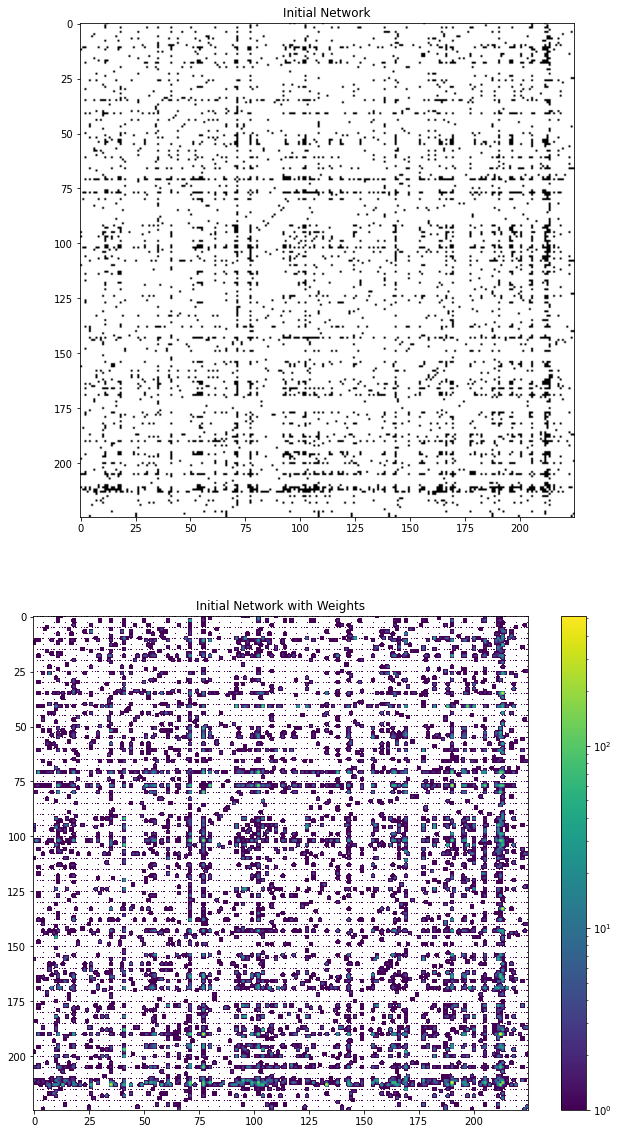

In [7]:
fig, ax = plt.subplots(ncols = 1, nrows = 2, figsize = (12, 20))
ax[0].imshow(initial_network, cmap = 'Greys')
ax[0].set_title("Initial Network")
im = ax[1].imshow(initial_network_weights, norm=matplotlib.colors.LogNorm())
ax[1].set_title("Initial Network with Weights")
#ax[1].colorbar()
fig.colorbar(im, ax=ax[1])
plt.show()

In [8]:
with open('data/initial_network.np', 'wb') as f:
    np.save(f, initial_network)
    
with open('data/initial_network_weights.np', 'wb') as f:
    np.save(f, initial_network_weights)